based on How to not overfit? Kaggle solution https://www.kaggle.com/artgor/how-to-not-overfit

In [0]:
import os
import json
import ast
import time
import datetime
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [0]:
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import linear_model
from sklearn.neighbors import NearestNeighbors

In [0]:
!pip install eli5

     |████████████████████████████████| 112kB 4.3MB/s 


In [0]:
!pip install shap

     |████████████████████████████████| 266kB 4.8MB/s 
  Created wheel for shap: filename=shap-0.34.0-cp36-cp36m-linux_x86_64.whl size=383193 sha256=01b232f8631b0127f7f75b85250dd2542997d5faf84d15046982f9b5b4196934
  Stored in directory: /root/.cache/pip/wheels/28/7e/28/57bc9fcb77579b0df6561298648249370648c0b91dfe42c8ec
Successfully built shap


In [0]:
import eli5
from eli5.sklearn import PermutationImportance
import shap

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
from sklearn.datasets import make_classification


### создание своего датасета (random seed, data exploration)

In [0]:
X, y = make_classification(n_classes=2,
    weights=[0.7, 0.3], 
    n_informative=40, n_redundant=45, n_features=200, 
    n_clusters_per_class=4, 
    n_samples=1000, random_state=4) #np.random.randint(10000)

In [0]:
X[:5, :4]

array([[ 0.66794613, -0.44650395,  5.64069283, -0.28023025],
       [-2.33136302,  2.49864479,  8.31145909, -0.75826268],
       [ 2.51575636,  0.34813661, -7.31985531, -0.53124425],
       [-0.23757112,  1.26118129, -8.42500608, -0.95282484],
       [ 0.27468395,  1.22836553,  6.83314928,  1.19859023]])

In [0]:
features = pd.DataFrame(X)

In [0]:
answers = pd.DataFrame(y)

In [0]:
features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,-1.646173,-4.050482,4.691288,-7.629997,1.463806,-0.274758,-0.156976,1.236675,-1.202408,0.482138,-0.996835,0.296080,-0.639570,5.897500,0.509118,0.706834,-3.361490,-0.913577,-0.275482,-0.253533,5.594465,27.388065,0.553098,-0.803602,0.895188,0.933435,-5.229545,-8.669636,-5.389767,-0.193383,-0.604365,0.592225,0.404233,-0.398601,-1.640394,-0.195317,0.629507,0.583635,0.581939,3.956217,4.823102,-4.078633,-4.946788,-1.839432,-10.180917,-1.518899,0.354688,1.372524,4.739895,-2.360195,-0.916845,-1.014601,-1.270589,1.283815,0.299982,-10.364614,-0.241633,7.373371,-1.513479,3.024093,0.978743,-16.500455,1.456480,-4.129909,0.566664,0.194444,-0.010657,-27.845800,-0.422318,2.642981,-0.645906,1.456078,-11.546272,-0.765799,-0.494046,0.054561,9.182333,0.450865,0.860813,12.462635,-0.581816,0.947641,0.532468,-0.025431,4.597429,0.215647,1.473131,-0.124262,2.274240,-6.847577,-6.853759,-1.132718,1.135945,-0.395725,0.344468,-0.717453,-5.409651,9.055512,-0.971911,0.270808,0.984733,1.683314,2.709628,-0.260370,-14.689156,0.976470,-1.667236,1.189654,-4.685076,-0.112585,3.118941,-0.699142,-1.421395,-1.718713,-0.532227,2.516099,-18.036832,0.806147,-0.332967,0.693091,-0.437587,-0.358519,3.601828,7.210023,-1.614276,0.003951,11.758573,-0.625839,2.518329,-8.908042,0.412707,-1.022627,7.804017,3.718838,-0.033635,0.079716,-0.767413,-0.002556,4.910736,-0.865486,-0.839125,10.085378,1.015557,10.102709,-0.542825,0.842520,-0.054219,-1.403012,-0.400488,-0.025699,0.328320,0.358196,-0.350227,-1.068945,-0.155021,0.296123,1.513284,0.186214,3.462471,12.088894,-0.401724,0.892177,-1.340482,-3.010511,-1.429891,-0.040710,-0.785880,-0.806824,-1.099177,-9.778312,2.113313,0.588180,-3.988550,-2.762374,0.991148,1.097984,0.294448,-0.366954,14.350608,4.484273,-0.021820,0.626588,-1.670523,-1.296018,0.101885,0.576533,0.213519,-1.012498,8.748146,-0.187205,0.196985,-1.346339,-24.005354,-15.382965,3.307767,-0.068670,19.078041,2.678616,1.794474,0.266006
1,-24.013025,-35.946523,-2.740862,1.334532,-0.360858,0.889978,0.004762,-0.239843,-0.841309,-2.329680,10.251765,-0.503681,0.284730,5.154991,-0.323786,0.094041,2.959227,-0.981304,1.642857,0.379257,0.676274,18.647183,0.502094,2.620346,-0.883505,-4.650392,0.873112,-4.195676,-1.712187,-0.286078,0.920253,0.504738,-1.560106,1.109286,2.286410,0.402472,-0.073745,1.626725,-0.743449,9.564708,14.654102,24.735514,-5.540737,-0.923330,40.361688,3.241695,-1.542231,0.054667,-5.723037,0.974838,-1.008723,1.468354,-0.500372,1.125836,-0.373200,-24.690747,-1.345174,-8.174478,3.902430,0.663709,-0.540266,-10.949621,-0.633198,2.113682,-0.652093,-0.636338,-0.768664,14.373032,0.093474,4.496942,1.461583,1.917833,-3.057437,0.189848,-0.338388,-0.871692,28.351390,0.253186,8.578362,-13.319615,0.308822,-2.030813,0.657156,-0.268292,-5.307063,2.445955,-1.870336,0.872996,-0.264528,-7.129876,6.544830,-0.806590,0.838238,2.048217,1.515334,-0.837156,-10.449494,17.155937,0.491743,-0.896734,-16.895142,3.025800,-6.695610,0.198516,-5.828727,0.208898,-14.953441,1.188381,-5.668681,0.759051,1.041453,-1.208974,1.922297,0.444111,0.496037,3.719725,2.895613,0.619597,1.289407,0.421647,0.777095,0.283250,-5.859428,-7.199743,-0.687916,-0.673849,-7.756085,8.042694,30.408078,10.277058,-0.405752,-0.502488,10.508740,0.413951,-0.430871,1.319269,-1.885646,-1.428340,25.909193,0.275242,-1.660123,-7.611746,0.816587,31.742347,1.

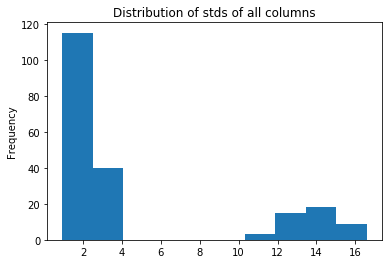

In [0]:
#данные не нормализованы
features.std().plot('hist');
plt.title('Distribution of stds of all columns');

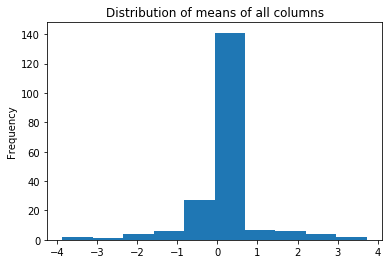

In [0]:
features.mean().plot('hist');
plt.title('Distribution of means of all columns');

In [0]:
# проверим, что нет пустых значений
features.isnull().any().any()

False

In [0]:
#дисбаланс классов
answers[0].value_counts()

0    699
1    301
Name: 0, dtype: int64

### обучение

In [0]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.70, random_state=42)

In [0]:
np.std(X_train, axis=0)

array([ 3.41198629,  1.00489231, 14.23659681,  1.09990458,  1.02075476,
        1.06162436,  1.00386156,  1.00071121, 13.1583946 ,  1.00813385,
        1.00497052, 14.04258851, 12.43978084,  0.9847298 ,  0.97038901,
        0.95379341,  3.53658886, 13.49527274,  1.01298341,  3.49584864,
        0.98627366,  0.98917397,  0.92550259,  1.08373243,  0.94013738,
        3.77869343,  3.75394974,  1.04083241,  0.89611033,  1.05369879,
        3.48085577,  1.00184181,  3.54691049,  0.98961839, 12.98089079,
        1.04173791,  0.95177015, 13.58622126,  3.50768903, 11.84733148,
        0.93086709,  1.00867287,  1.00985423,  0.99650833, 10.4934983 ,
        0.99875776, 13.13917884, 12.99306294, 10.23453757,  0.9172677 ,
        4.03884785,  1.10826003,  1.0149117 ,  0.98541777,  1.01814108,
       13.00138334, 14.62813851, 11.82147217,  3.69204389,  1.03209593,
        1.01867176, 12.64847574,  3.81356116, 14.61457874,  1.02513838,
        0.98143715,  3.88916812,  0.97048552,  4.08453267,  1.04

In [0]:
#Нормируем данные
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [0]:
np.mean(X_train, axis=0)

array([-4.07081776e-17,  1.20274161e-17,  5.01450733e-17, -3.70074342e-17,
        4.44089210e-18, -2.70385566e-17,  2.33146835e-17, -8.88178420e-18,
       -5.62512999e-17,  3.58972111e-17,  1.70234197e-17,  1.88610701e-16,
        4.62592927e-18,  3.33066907e-17,  2.88657986e-17,  2.14643118e-17,
       -8.14163551e-18,  4.44089210e-18, -2.81256500e-17,  1.37667655e-16,
       -5.92118946e-18,  3.09012075e-17, -1.13242749e-16,  3.70074342e-18,
        1.81336427e-17, -3.44169138e-17,  7.51250913e-17, -2.96059473e-18,
        3.83026943e-17,  9.06682137e-18, -4.44089210e-18,  5.56036698e-17,
        4.07081776e-17, -5.18104078e-18, -8.79851747e-17, -2.73855013e-17,
        3.10862447e-17, -8.17864295e-17, -2.81256500e-17,  1.22124533e-17,
        1.70234197e-17,  5.62512999e-17,  3.47869881e-17,  2.22044605e-18,
       -3.70074342e-17, -9.99200722e-18,  6.80936788e-17,  6.66133815e-17,
        1.27675648e-17, -1.34336986e-16, -1.25825276e-17, -3.88578059e-17,
       -2.22044605e-18, -

## как оценить примерное качество модели, если тест закрыт?

In [0]:
# обучимся на том, что есть, и оценим качество предсказаний на трейне
model = linear_model.LogisticRegression()
model = model.fit(X_train, y_train)
train_preds = model.predict_proba(X_train)[:, 1]
test_preds = model.predict_proba(X_test)[:, 1]

In [0]:
print('result on train: {}'.format(roc_auc_score(y_train, train_preds)))
print('result on test: {}'.format(roc_auc_score(y_test,test_preds)))

result on train: 1.0
result on test: 0.6726268943711531


### Overfitting!

![](https://i.stack.imgur.com/1QU0m.png)

## Cross Validation (+ stratification)

![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

### KFold, StratifiedKFold, RepeatedStratifiedKFold

In [0]:
n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=0)
stratified_folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=0)
repeated_folds = RepeatedStratifiedKFold(n_splits=n_fold, n_repeats=20, random_state=0)

In [0]:
for train_index, valid_index in folds.split(X_train, y_train):
    print("TRAIN:", len(train_index), "TEST:", len(valid_index))
    print('number of positives {}'.format(int(sum(y_train[valid_index]))))

TRAIN: 200 TEST: 100
number of positives 38
TRAIN: 200 TEST: 100
number of positives 28
TRAIN: 200 TEST: 100
number of positives 33


In [0]:
for train_index, valid_index in stratified_folds.split(X_train, y_train):
    print("TRAIN:", len(train_index), "TEST:", len(valid_index))
    print('number of positives {}'.format(int(sum(y_train[valid_index]))))

TRAIN: 285 TEST: 15
number of positives 5
TRAIN: 285 TEST: 15
number of positives 5
TRAIN: 285 TEST: 15
number of positives 5
TRAIN: 285 TEST: 15
number of positives 5
TRAIN: 285 TEST: 15
number of positives 5
TRAIN: 285 TEST: 15
number of positives 5
TRAIN: 285 TEST: 15
number of positives 5
TRAIN: 285 TEST: 15
number of positives 5
TRAIN: 285 TEST: 15
number of positives 5
TRAIN: 285 TEST: 15
number of positives 5
TRAIN: 285 TEST: 15
number of positives 5
TRAIN: 285 TEST: 15
number of positives 5
TRAIN: 285 TEST: 15
number of positives 5
TRAIN: 285 TEST: 15
number of positives 5
TRAIN: 285 TEST: 15
number of positives 5
TRAIN: 285 TEST: 15
number of positives 5
TRAIN: 285 TEST: 15
number of positives 5
TRAIN: 285 TEST: 15
number of positives 5
TRAIN: 285 TEST: 15
number of positives 5
TRAIN: 285 TEST: 15
number of positives 4


In [0]:
def cv_train_model(X, y, X_test, y_test, folds=folds, plot_feature_importance=False, model=None):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    valid_scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
          

        model.fit(X_train, y_train)      
        y_pred_test = model.predict_proba(X_test)[:, 1]
        y_pred_valid = model.predict_proba(X_valid)[:, 1]
        valid_score = roc_auc_score(y_valid, y_pred_valid)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        valid_scores.append(valid_score)
        prediction += y_pred_test  
        
    prediction /= (fold_n + 1)
    test_score = roc_auc_score(y_test, prediction)
    print('Cross Validation mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(valid_scores), np.std(valid_scores)))
    print("Score on test data: {0:.4f}".format(test_score))
    

    return oof, prediction, valid_scores

In [0]:
model = linear_model.LogisticRegression()
oof_lr, prediction_lr, scores = cv_train_model(X_train, y_train, X_test, y_test,  model=model,  folds=folds)

Cross Validation mean score: 0.6736, std: 0.1356.
Score on test data: 0.6896


In [0]:
scores

[0.6527777777777778,
 0.7272727272727273,
 0.43518518518518523,
 0.595,
 0.5406698564593302,
 0.8447204968944099,
 0.8888888888888888,
 0.8095238095238095,
 0.631578947368421,
 0.61]

In [0]:
# попробуем другие разбиения на трейн и валидацию
model = linear_model.LogisticRegression() # penalty='l1', C=0.1
oof_lr, prediction_lr_stratified, scores = cv_train_model(X_train, y_train, X_test, y_test, model=model,  folds=stratified_folds)

Cross Validation mean score: 0.6781, std: 0.1010.
Score on test data: 0.6870


In [0]:
model = model.fit(X_train, y_train)
train_preds = model.predict_proba(X_train)[:, 1]
test_preds = model.predict_proba(X_test)[:, 1]
print('result on train: {}'.format(roc_auc_score(y_train, train_preds)))
print('result on test: {}'.format(roc_auc_score(y_test,test_preds)))

result on train: 1.0
result on test: 0.6726268943711531


In [0]:
model = linear_model.LogisticRegression(penalty = 'l1', solver = 'liblinear')
oof_lr, prediction_lr_repeated, scores = cv_train_model(X_train, y_train, X_test, y_test,  model=model, folds=repeated_folds)

Cross Validation mean score: 0.6660, std: 0.0941.
Score on test data: 0.6908



## ELI5

ELI5 позволяет смотреть на вклад разных признаков 

In [0]:
eli5.show_weights(model, top=50)

Weight?,Feature
+1.241,x121
+1.048,x84
+0.927,x125
+0.826,x69
+0.729,x159
+0.722,x86
+0.718,x106
+0.681,x30
+0.595,x189
+0.578,x88


Выберем признаки, вносящие, максимальный вклад, и оставим только их

In [0]:
sum(sum(model.coef_ != 0))


122

In [0]:
eli5.formatters.as_dataframe.explain_weights_df(model)

,target,feature,weight
0,1,x121,1.240749
1,1,x84,1.048368
2,1,x125,0.927326
3,1,x69,0.825571
4,1,x159,0.728960
...,...,...,...
118,1,x76,-0.918474
119,1,x15,-1.054850
120,1,x168,-1.121052
121,1,x78,-1.694175


In [0]:
top_features = [int(i[1:]) for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i]

In [0]:
top_features

[121,
 84,
 125,
 69,
 159,
 86,
 106,
 30,
 189,
 88,
 21,
 169,
 27,
 153,
 2,
 110,
 46,
 96,
 83,
 71,
 50,
 181,
 41,
 37,
 9,
 54,
 3,
 182,
 36,
 53,
 13,
 177,
 108,
 18,
 22,
 105,
 5,
 66,
 104,
 100,
 190,
 188,
 91,
 160,
 161,
 35,
 63,
 92,
 43,
 80,
 79,
 197,
 118,
 150,
 136,
 196,
 1,
 171,
 187,
 24,
 40,
 180,
 191,
 185,
 116,
 146,
 135,
 33,
 149,
 62,
 23,
 10,
 199,
 144,
 112,
 113,
 75,
 64,
 28,
 58,
 81,
 49,
 154,
 139,
 155,
 178,
 183,
 175,
 98,
 38,
 131,
 115,
 167,
 133,
 67,
 140,
 107,
 74,
 117,
 147,
 93,
 198,
 48,
 132,
 51,
 176,
 6,
 16,
 20,
 94,
 101,
 184,
 186,
 192,
 11,
 195,
 14,
 12,
 76,
 15,
 168,
 78]

In [0]:
X_train_eli5 = X_train[:,top_features]
X_test_eli5 = X_test[:,top_features]

In [0]:
eli5_model = linear_model.LogisticRegression() #penalty = 'l1'
oof_lr, prediction_lr, _ = cv_train_model(X_train_eli5, y_train, X_test_eli5, y_test, model=eli5_model, folds = folds)

Cross Validation mean score: 0.7812, std: 0.1095.
Score on test data: 0.6801


In [0]:
eli5_model = model.fit(X_train_eli5, y_train)
train_preds = eli5_model.predict_proba(X_train_eli5)[:, 1]
test_preds = eli5_model.predict_proba(X_test_eli5)[:, 1]
print('result on train: {}'.format(roc_auc_score(y_train, train_preds)))
print('result on test: {}'.format(roc_auc_score(y_test,test_preds)))

result on train: 0.9978893411729233
result on test: 0.6841343628272095


### Permutation importance
другой способ посмотреть на важность признаков  - Permutation importance
* Обучаем модель
* Во время валидации смешиваем случайным образом данные в одной из колонок
* Чем сильнее падает метрика, тем важнее признак

см.: https://www.kaggle.com/dansbecker/permutation-importance

In [0]:
X_train.shape

(300, 200)

In [0]:
perm = PermutationImportance(model, random_state=1).fit(X_train, y_train)

In [0]:
eli5.show_weights(perm, top=50)

Weight,Feature
0.0560 ± 0.0136,x86
0.0533 ± 0.0211,x18
0.0527 ± 0.0181,x53
0.0453 ± 0.0331,x49
0.0440 ± 0.0195,x26
0.0367 ± 0.0094,x164
0.0353 ± 0.0068,x179
0.0353 ± 0.0200,x8
0.0233 ± 0.0152,x195
0.0213 ± 0.0100,x19


In [0]:
weights = eli5.formatters.as_dataframe.explain_weights_df(perm)

In [0]:
top_features = [int(i[1:]) for i in weights[weights.weight != 0].feature if 'BIAS' not in i]

In [0]:
X_train_perm = X_train[:,top_features]
X_test_perm = X_test[:,top_features]

In [0]:
X_test_perm.shape

(700, 106)

In [0]:
perm_model = linear_model.LogisticRegression()
oof_lr1, prediction_lr1, _ = cv_train_model(X_train_perm, y_train, X_test_perm, y_test, model=perm_model)

Cross Validation mean score: 0.7972, std: 0.1079.
Score on test data: 0.6859


In [0]:
perm_model = perm_model.fit(X_train_perm, y_train)
train_preds = perm_model.predict_proba(X_train_perm)[:, 1]
test_preds = perm_model.predict_proba(X_test_perm)[:, 1]
print('result on train: {}'.format(roc_auc_score(y_train, train_preds)))
print('result on test: {}'.format(roc_auc_score(y_test,test_preds)))

result on train: 0.9966329966329966
result on test: 0.6830044305240309


## SHAP

Еще можно использовать SHAP для визуализации важности признаков

In [0]:
model = linear_model.LogisticRegression()
oof_lr1, prediction_lr1, _ = cv_train_model(X_train, y_train, X_test, y_test,  model=model, folds = folds)

Cross Validation mean score: 0.6736, std: 0.1356.
Score on test data: 0.6896


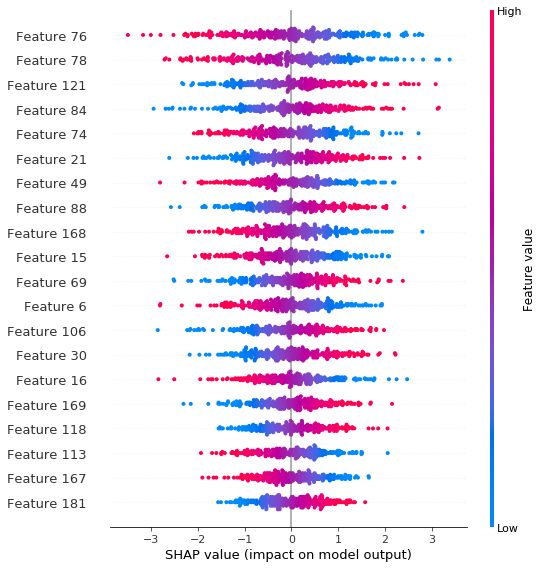

In [0]:
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

В некоторых моделях, например в деревьях решений, есть встроенный метод feature_importances_

In [0]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
train_preds = dtc.predict_proba(X_train)[:, 1]
test_preds = dtc.predict_proba(X_test)[:, 1]
print('result on train: {}'.format(roc_auc_score(y_train, train_preds)))
print('result on test: {}'.format(roc_auc_score(y_test,test_preds)))


result on train: 1.0
result on test: 0.5016011864839078


In [0]:
feature_importance = pd.DataFrame()
feature_importance["feature"] = features.columns
feature_importance["importance"] = dtc.feature_importances_
feature_importance[["feature", "importance"]].sort_values(by = 'importance', ascending = False)[:20]

,feature,importance
196,196,0.090909
121,121,0.087154
128,128,0.064566
114,114,0.062856
8,8,0.061385
74,74,0.057648
19,19,0.047852
25,25,0.043388
106,106,0.041539
50,50,0.040460


## Grid Search

![](https://www.kdnuggets.com/wp-content/uploads/hyper-parameter-search.jpg)

In [0]:
%%time

#np.arange(0,2,.5)
#np.linspace(0,2,10)

lr = linear_model.LogisticRegression()

parameter_grid = {'class_weight' : ['balanced', None],
                  'penalty' : ['l2', 'l1'],
                  'solver' : ['liblinear', 'saga'],
                  'C' : [0.001, 0.01, 0.08, 0.1, 0.15, 1.0, 10.0, 100.0],
                  'max_iter': [2,10,50,100,1000]
                 }

grid_search = GridSearchCV(lr, param_grid=parameter_grid, cv=folds, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.7734058534058535
Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 10, 'penalty': 'l1', 'solver': 'liblinear'}
CPU times: user 4min 56s, sys: 192 ms, total: 4min 56s
Wall time: 4min 56s


In [0]:
model = linear_model.LogisticRegression(C = 0.1, class_weight= 'balanced', max_iter = 10, penalty = 'l1', solver = 'liblinear')
oof_lr, prediction_lr, scores = cv_train_model(X_train, y_train, X_test, y_test,  model=model, folds = stratified_folds)

Cross Validation mean score: 0.7038, std: 0.1179.
Score on test data: 0.7342


In [0]:
model = model.fit(X_train, y_train)
train_preds = model.predict_proba(X_train)[:, 1]
test_preds = model.predict_proba(X_test)[:, 1]
print('result on train: {}'.format(roc_auc_score(y_train, train_preds)))
print('result on test: {}'.format(roc_auc_score(y_test,test_preds)))

result on train: 0.8845168098899442
result on test: 0.7278449019238584


### примеры с другими моделями

In [0]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()

parameter_grid = {'splitter' : ['best', 'random'],
                  'max_depth' : [2, 3, 4, 5, 10, 20, 30]}

grid_search = GridSearchCV(dtc, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
dtc = DecisionTreeClassifier(**grid_search.best_params_)
oof_knc, prediction_knc, scores_knc = cv_train_model(X_train, y_train, X_test, y_test,  model=knc, folds = stratified_folds)

In [0]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier()

parameter_grid = {'n_neighbors': [2, 3, 5, 10, 20, 30],
                  'weights': ['uniform', 'distance']}

grid_search = GridSearchCV(knc, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
knc = KNeighborsClassifier(**grid_search.best_params_)
oof_knc, prediction_knc, scores_knc = cv_train_model(X_train, y_train, X_test, y_test,  model=knc, folds = stratified_folds)

Best score: 0.7533234080734081
Best parameters: {'n_neighbors': 10, 'weights': 'uniform'}
Cross Validation mean score: 0.7375, std: 0.1375.
Score on test data: 0.6733


In [0]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()

parameter_grid = {'alpha': [1e-06, 1e-04, 0.001, 0.1, 2, 10] }

grid_search = GridSearchCV(bnb, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
bnb = BernoulliNB(**grid_search.best_params_)
oof_bnb, prediction_bnb, scores_bnb = cv_train_model(X_train, y_train, X_test, y_test,  model=bnb, folds = stratified_folds)

Best score: 0.7126741776741776
Best parameters: {'alpha': 1e-06}
Cross Validation mean score: 0.6841, std: 0.1159.
Score on test data: 0.6769


In [0]:
from sklearn.svm import SVC
svc = SVC(probability=True, gamma='scale')

parameter_grid = {'C': [0.001, 0.01, 0.1, 1.0, 10.0],
                  'kernel': ['linear', 'poly', 'rbf'],
                 }

grid_search = GridSearchCV(svc, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
svc = SVC(probability=True, gamma='scale', **grid_search.best_params_)
oof_svc, prediction_svc, scores_svc = cv_train_model(X_train, y_train, X_test, y_test,  model=svc, folds = stratified_folds)

Best score: 0.7481558904058905
Best parameters: {'C': 10.0, 'kernel': 'poly'}
Cross Validation mean score: 0.7352, std: 0.1201.
Score on test data: 0.7062
